In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
# Step 1: Load the data
data = pd.read_csv('../roi_data_pn_2_processed.csv')

# Find the column labeled 'Label'
X = data.drop(['filename', 'Breed', 'Label'], axis=1)
y = data['Label']


In [3]:
X.shape

(294, 600)

In [4]:
def string_to_reshaped_array(s):
    array_np = string_to_array(s)
    return array_np.reshape(int(array_np.shape[0]**0.5), int(array_np.shape[0]**0.5), 1)

def string_to_array(s):
    # Remove unnecessary characters and split the string into lines
    clean_str = s.replace('[', '').replace(']', '').strip()
    lines = clean_str.split('\n')

    # Process each line to convert it into a list of numbers
    array_list = []
    for line in lines:
        numbers = [int(num.strip()) for num in line.split() if num.strip().isdigit()]
        if len(numbers) > 0:
            array_list.append(numbers)

    # Convert the list of lists into a numpy array and reshape
    array_np = np.array(array_list)
    return array_np

def normalize_curves(curves):
    min_values = [np.min(curve) for curve in curves]
    min_value = np.min(min_values)
    return [curve - np.min(curve) + min_value for curve in curves]

In [5]:
X_df = X.applymap(string_to_array)

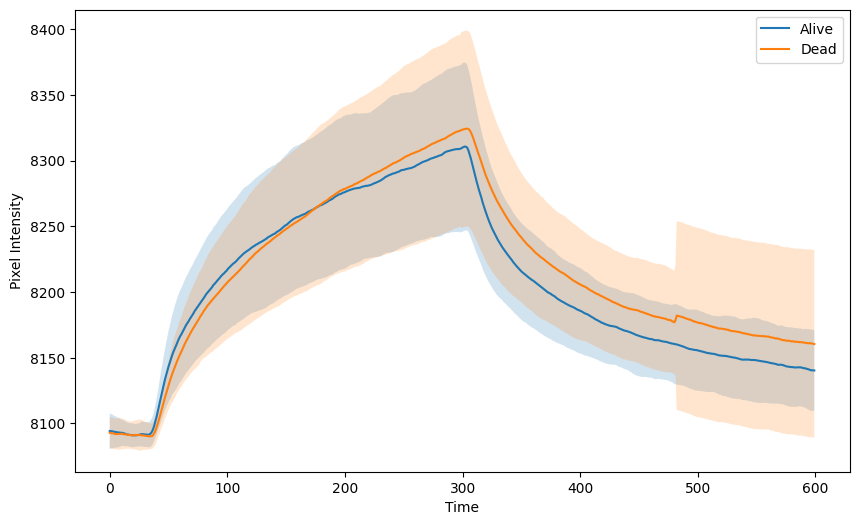

In [6]:
# get all means and stds
means = []
for i in range(X_df.shape[0]):
    mean = []
    for j in range(X_df.shape[1]):
        data = X_df.iloc[i, j]
        mean.append(np.mean(data))
    means.append(mean)


# Convert 'means' and 'stds' lists to numpy arrays for easier manipulation
means = np.array(normalize_curves(means))
half_index = int(means.shape[0] / 2)-1

mean_alive = np.mean(means[:half_index], axis=0)
mean_dead = np.mean(means[half_index:], axis=0)
std_alive = np.std(means[:half_index], axis=0)
std_dead = np.std(means[half_index:], axis=0)

# Plotting
plt.figure(figsize=(10, 6))

# Plot for 'Alive'
plt.plot(mean_alive, label='Alive')
plt.fill_between(range(len(mean_alive)), 
                 mean_alive - std_alive, 
                 mean_alive + std_alive, 
                 alpha=0.2)

# Plot for 'Dead'
plt.plot(mean_dead, label='Dead')
plt.fill_between(range(len(mean_dead)), 
                 mean_dead - std_dead, 
                 mean_dead + std_dead, 
                 alpha=0.2)

# Setting labels and legend
plt.xlabel('Time')
plt.ylabel('Pixel Intensity')
plt.legend()
plt.show()

In [7]:
# Apply the conversion function to each cell in the DataFrame
X_processed = X.applymap(string_to_reshaped_array)

# Initialize an empty list to hold the flattened arrays
X_flattened_list = []

# Iterate through each row
for _, row in X_processed.iterrows():
    # Flatten each non-NaN element and append to the list
    row_flattened = [element.flatten() for element in row if isinstance(element, np.ndarray)]
    if row_flattened:  # If row is not empty
        X_flattened_list.append(np.concatenate(row_flattened))

# Convert the list of flattened arrays to a NumPy array
X_flattened = np.array(X_flattened_list)


In [8]:
# Normalize the data

X_flattened_normalized = np.zeros(X_flattened.shape, dtype=float)
for i in range(X_flattened.shape[0]):
    row_min = X_flattened[i].min()
    row_max = X_flattened[i].max()
    if row_max > row_min:
        X_flattened_normalized[i] = (X_flattened[i] - row_min) / (row_max - row_min)
    else:
        X_flattened_normalized[i] = X_flattened[i]

In [9]:
# ml analysis on normalized data

ml_list = [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, SVC, KNeighborsClassifier]

for ml in ml_list:
    model = ml()
    print("Model:", model)
    cv_scores = cross_val_score(model, X_flattened_normalized, y, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", np.mean(cv_scores))
    X_train, X_test, y_train, y_test = train_test_split(X_flattened_normalized, y, test_size=0.2, random_state=42)
    y_pred = model.fit(X_train, y_train).predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("----------------------------")

Model: DecisionTreeClassifier()
Cross-validation scores: [0.62711864 0.62711864 0.62711864 0.74576271 0.56896552]
Mean cross-validation score: 0.6392168322618352
Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.81      0.79        27
        True       0.83      0.78      0.81        32

    accuracy                           0.80        59
   macro avg       0.80      0.80      0.80        59
weighted avg       0.80      0.80      0.80        59

Confusion Matrix:
 [[22  5]
 [ 7 25]]
----------------------------
Model: RandomForestClassifier()
Cross-validation scores: [0.79661017 0.74576271 0.72881356 0.81355932 0.60344828]
Mean cross-validation score: 0.7376388077147866
Classification Report:
               precision    recall  f1-score   support

       False       0.71      0.81      0.76        27
        True       0.82      0.72      0.77        32

    accuracy                           0.76        59
   macro avg    

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Cross-validation scores: [0.6779661  0.69491525 0.6779661  0.79661017 0.5862069 ]
Mean cross-validation score: 0.6867329047340737


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

       False       0.68      0.63      0.65        27
        True       0.71      0.75      0.73        32

    accuracy                           0.69        59
   macro avg       0.69      0.69      0.69        59
weighted avg       0.69      0.69      0.69        59

Confusion Matrix:
 [[17 10]
 [ 8 24]]
----------------------------
Model: SVC()
Cross-validation scores: [0.71186441 0.69491525 0.71186441 0.83050847 0.55172414]
Mean cross-validation score: 0.7001753360607832
Classification Report:
               precision    recall  f1-score   support

       False       0.66      0.70      0.68        27
        True       0.73      0.69      0.71        32

    accuracy                           0.69        59
   macro avg       0.69      0.70      0.69        59
weighted avg       0.70      0.69      0.70        59

Confusion Matrix:
 [[19  8]
 [10 22]]
----------------------------
Model: KNeighborsClas

Decision Tree

In [10]:
# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Use k-fold cross-validation (e.g., k=5)
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Cross-validation scores: [0.66101695 0.61016949 0.74576271 0.71186441 0.63793103]
Mean cross-validation score: 0.6733489187609585
Classification Report:
               precision    recall  f1-score   support

       False       0.58      0.74      0.65        39
        True       0.74      0.58      0.65        50

    accuracy                           0.65        89
   macro avg       0.66      0.66      0.65        89
weighted avg       0.67      0.65      0.65        89

Confusion Matrix:
 [[29 10]
 [21 29]]


Random Forest

In [11]:
clf = RandomForestClassifier()

# Use the same cross-validation approach
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Cross-validation scores: [0.71186441 0.69491525 0.66101695 0.66101695 0.5862069 ]
Mean cross-validation score: 0.6630040911747516
Classification Report:
               precision    recall  f1-score   support

       False       0.62      0.82      0.70        39
        True       0.81      0.60      0.69        50

    accuracy                           0.70        89
   macro avg       0.71      0.71      0.70        89
weighted avg       0.73      0.70      0.70        89

Confusion Matrix:
 [[32  7]
 [20 30]]


In [12]:
clf = LogisticRegression()

# Use the same cross-validation approach
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Cross-validation scores: [0.74576271 0.69491525 0.77966102 0.72881356 0.63793103]
Mean cross-validation score: 0.717416715371128
Classification Report:
               precision    recall  f1-score   support

       False       0.68      0.72      0.70        39
        True       0.77      0.74      0.76        50

    accuracy                           0.73        89
   macro avg       0.73      0.73      0.73        89
weighted avg       0.73      0.73      0.73        89

Confusion Matrix:
 [[28 11]
 [13 37]]


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
clf = SVC()

# Use the same cross-validation approach
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Cross-validation scores: [0.62711864 0.66101695 0.6440678  0.59322034 0.56896552]
Mean cross-validation score: 0.6188778492109879
Classification Report:
               precision    recall  f1-score   support

       False       0.61      0.72      0.66        39
        True       0.74      0.64      0.69        50

    accuracy                           0.67        89
   macro avg       0.68      0.68      0.67        89
weighted avg       0.68      0.67      0.68        89

Confusion Matrix:
 [[28 11]
 [18 32]]


In [14]:
clf = KNeighborsClassifier()

# Use the same cross-validation approach
cv_scores = cross_val_score(clf, X_flattened, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.3, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model using different metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Cross-validation scores: [0.66101695 0.6779661  0.72881356 0.62711864 0.56896552]
Mean cross-validation score: 0.6527761542957335
Classification Report:
               precision    recall  f1-score   support

       False       0.55      0.69      0.61        39
        True       0.70      0.56      0.62        50

    accuracy                           0.62        89
   macro avg       0.63      0.63      0.62        89
weighted avg       0.63      0.62      0.62        89

Confusion Matrix:
 [[27 12]
 [22 28]]
